# Fish Detection
This notebook is taken from [pytorch.org](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).property

License: BSD
Author: Sasank Chilamkurthy

## Dependencies
torch torchvision numpy matplotlib ipykernel opencv-python


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

In [3]:
DATASET_DIR = "/home/khai/mounted_drives/documents/computer_vision/fish_classification_data/Annotation/task_fish_detection-2024_01_28_18_07_53-cvat-for-video-1.1.zip/images"
ANNOTATIONS_DIR = "/home/khai/mounted_drives/documents/computer_vision/fish_classification_data/Annotation/task_fish_detection-2024_01_28_18_07_53-cvat-for-video-1.1.zip/"

In [4]:
# data_transforms = {
#     "train": transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     "val": transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])
# }

# image_datasets = { x: datasets.ImageFolder(os.path.join(DATASET_PATH, x),
#                                            data_transforms[x])
#                    for x in ["train", "val"] }

# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}

# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Test on Single Sample
Let's create a test on a single image. We create a bounding box around the fish
per annotation and label it "fish".

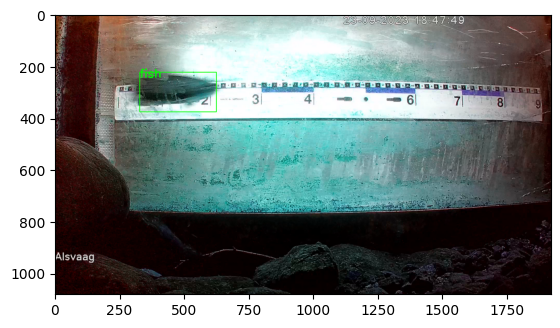

In [5]:
import cv2
import matplotlib.pyplot as plt

import xml.etree.ElementTree as ET

image_name = "frame_000070.PNG"
xml_name = "annotations.xml"

# Put together image
img = cv2.imread(os.path.join(DATASET_DIR, image_name))
cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB

# Put together annotations
tree = ET.parse(os.path.join(ANNOTATIONS_DIR, xml_name))
root = tree.getroot()

annotation_color = (0, 255, 0)

# Extract bounding boxes from the annoations (if any)
# <box frame="70" outside="0" occluded="0" keyframe="0" xtl="327.46" ytl="224.60" xbr="623.15" ybr="377.17" z_order="0">
box_frames_collection = root.find("track")
assert box_frames_collection is not None, "Cannot find the 'track' tag in the annotations"

box_frames = list()

# Extract all annoation datas for each frame
for element in box_frames_collection:
    xtl = int(float(element.attrib.get('xtl')))
    ytl = int(float(element.attrib.get('ytl')))
    xbr = int(float(element.attrib.get('xbr')))
    ybr = int(float(element.attrib.get('ybr')))
    box_frames.append({
        "frame": element.attrib.get('frame'),
        "x": xtl,
        "width": xbr - xtl,
        "y": ytl,
        "height": ybr - ytl,
    })

fbox = dict()
for e in box_frames:
    if e.get("frame") == "70":
        fbox = e
        break


# BGR colour space
cv2.rectangle(img,
            (fbox.get("x"), fbox.get("y")),
            (fbox.get("x") + fbox.get("width"), fbox.get("y") + fbox.get("height")),
            annotation_color,
            2)

# Annotate the box
text_position = (fbox.get("x"), fbox.get("y") + 20)
text_size = 1.5
text_thickness = 3
cv2.putText(img, "fish", text_position, cv2.FONT_HERSHEY_SIMPLEX, text_size, annotation_color, thickness=text_thickness)

plt.imshow(img)
plt.show()

# Label Video Clip
This time, we will use a video clip to create a bounding box around the fish and
also label it. We'll convert the above cell to a function.

Credit to [YingqiangGao](https://stackoverflow.com/users/7759152/yingqiang-gao) at [StackOverflow](https://stackoverflow.com/q/43048725) for the code with writing to video.

## Video Specifications
FPS: 25 (Based eye judgement; 24 is too slow and 30 is too quick)
Dimensions: 1920x1080


In [56]:
def label_frame(
        img_path: str, frame_num: str, verbose=False) -> np.ndarray:
    image_name = img_path
    xml_name = "annotations.xml"

    # Get image
    img = cv2.imread(os.path.join(DATASET_DIR, image_name))
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB

    # Get bounding boxes from annotations
    tree = ET.parse(os.path.join(ANNOTATIONS_DIR, xml_name))
    box_frames_collection = tree.getroot().find("track")
    assert box_frames_collection is not None, "Cannot find the 'track' tag in the annotations"

    # Set bounding box and label colour
    annotation_color = (0, 255, 0)

    bframes = dict() # List of all boxes

    if verbose:
        print(f"Labelling frame: {frame_num}", end='\r')

    # Extract all annoation datas for each frame
    for element in box_frames_collection:
        xtl = int(float(element.attrib.get('xtl')))
        ytl = int(float(element.attrib.get('ytl')))
        xbr = int(float(element.attrib.get('xbr')))
        ybr = int(float(element.attrib.get('ybr')))
        bframes[element.attrib.get('frame')] = {
            "x": xtl,
            "width": xbr - xtl,
            "y": ytl,
            "height": ybr - ytl,
        }
    
    if bframes.get(frame_num) is not None:
        # Create bounding box
        cv2.rectangle(img,
                    (bframes.get(frame_num).get("x"), bframes.get(frame_num).get("y")),
                    (bframes.get(frame_num).get("x") + bframes.get(frame_num).get("width"), bframes.get(frame_num).get("y") + bframes.get(frame_num).get("height")),
                    annotation_color,
                    2)

        # Annotate the box
        text_position = (bframes.get(frame_num).get("x"), bframes.get(frame_num).get("y") + 20)
        text_size = 1.5
        text_thickness = 3
        cv2.putText(img, "fish", text_position, cv2.FONT_HERSHEY_SIMPLEX, text_size, annotation_color, thickness=text_thickness)

    # plt.imshow(img)
    # plt.show()
        
    return img

In [60]:
images = os.listdir(DATASET_DIR)
images.sort()
labelled_images = list()

# Get width and height
img_for_size = cv2.imread(os.path.join(DATASET_DIR, image_name))

width = img_for_size.shape[0]
height = img_for_size.shape[1]
!mkdir output
video = cv2.VideoWriter('output/video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 25.0, (1920, 1080))

for i, img in enumerate(images):
    rendered_frame = label_frame(img_path=img,frame_num=str(i), verbose=True)
    video.write(rendered_frame)

    if i == 3: break


cv2.destroyAllWindows()
video.release()